In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Pretrained GAN

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [0]:
datapath = Path('/content/drive/My Drive/fast.ai v3/datasets/oxford-iiit-pet')
path_hr = datapath/'images' # high res version
path_lr = datapath/'crappy' # crappified version

# Preparing input: Crappifier

In [0]:
from PIL import Image, ImageDraw, ImageFont

class crappifier():
    def __init__(self,path_lr,path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr

    def __call__(self,fn,i):
        dest = self.path_lr/fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True,exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img,96,use_min=True)
        img = img.resize(targ_sz,resample = PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)),str(q),fill=(random.randint(100,200),random.randint(100,200),random.randint(100,200)))
        img.save(dest,quality=q)


In [0]:
il = ImageList.from_folder(path_hr)

In [7]:
il

ImageList (7390 items)
Image (3, 200, 200),Image (3, 482, 500),Image (3, 500, 375),Image (3, 500, 375),Image (3, 333, 500)
Path: /content/drive/My Drive/fast.ai v3/datasets/oxford-iiit-pet/images

In [8]:
parallel(crappifier(path_lr,path_hr),il.items)

KeyboardInterrupt: ignored

In [0]:
bs,size = 32,128
arch = models.resnet34

# Pretraining the Generator

In [0]:
# ImageImage not a typo, refer docs for differences between ImageImageList and ImageList
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1,seed = 0)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data_gen = get_data(bs,size)

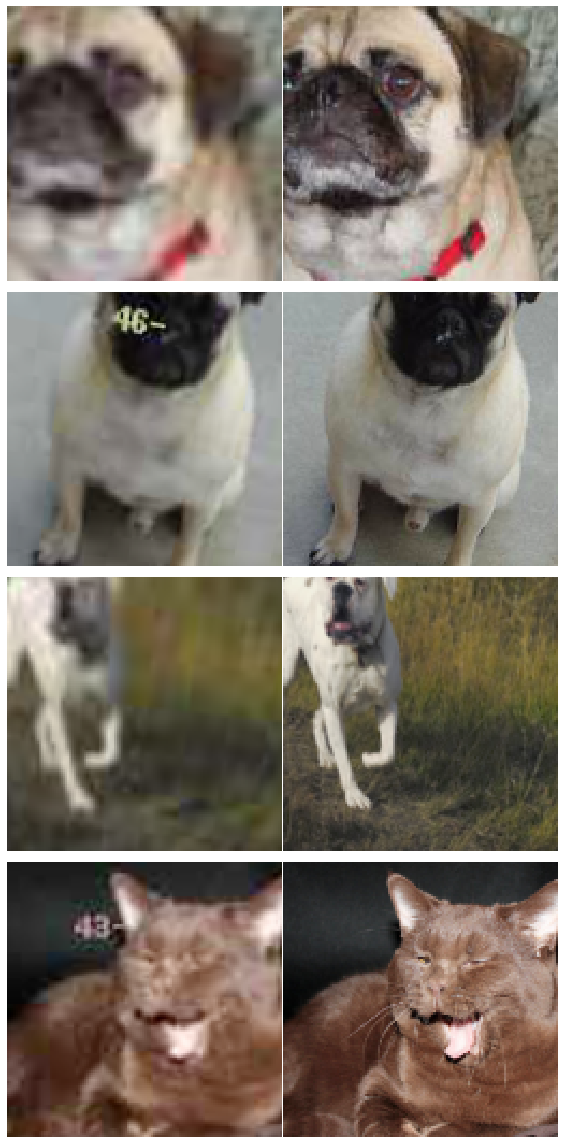

In [25]:
data_gen.show_batch(4)

In [0]:
wd = 1e-3

In [0]:
y_range = (-3.,3.)

In [0]:
loss_gen =  MSELossFlat()

In [0]:
def create_gen_learner():
    return unet_learner(data_gen,arch,wd=wd,blur=True,
                        self_attention=True,y_range=y_range,
                        loss_func = loss_gen)

In [30]:
doc(unet_learner)

In [31]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 91.9MB/s]


In [0]:
learn_gen.fit_one_cycle(2,pct_start=0.8)

epoch,train_loss,valid_loss,time
